# Lab 2 - ENSF 511 - Transfer Learning
### Part 2 - New Model Analysis
Name: Joel Aaron Marquez

The Fastai will be used for an easy and high-level method to train and develop a model for bobcat detection on top of the cifar10 dataset. Reference for the process on Fastai (this document is for Ver. 1 of the FastAi library, so it is outdated): https://kdorichev.github.io/deeplearning//Image_Classification_CIFAR_10#Getting-the-Data

In [1]:
# Libraries

from fastai import *
from fastai.vision.all import *
from fastai.callback import *
import os
from shutil import copyfile
import re

##### 1. Preparing the Dataset

Cifar10 has ten labels with 5000 images in train and 1000 images in test for each label (6000 in total)

In [2]:
path = untar_data(URLs.CIFAR) 

In [3]:
(path).ls()

(#3) [Path('C:/Users/User/.fastai/data/cifar10/labels.txt'),Path('C:/Users/User/.fastai/data/cifar10/test'),Path('C:/Users/User/.fastai/data/cifar10/train')]

It may not be the most sophisticated solution but to add on the bobcat dataset, I will have to append the bobcat category on the labels.txt file (**unsure if not doing so will cause issues**) and transfer the first 5000 bobcat images on the training folder, and the remaining 1000 bobcat images in the testing folder.

In [4]:
# 1. adding the bobcat label on the labels.txt (unsure if it makes a difference)

with open('C:/Users/User/.fastai/data/cifar10/labels.txt', 'r+') as text:
    
    line = text.readlines()[-1]
    
    if line != 'bobcat':
        text.write('\nbobcat')

In [5]:
# 2. Transferring the bobcat images to the train and test folders

bobcat_path = list()

# Load in the bobcat images
for filepath in os.listdir('C:/Users/User/Desktop/ENSF511_Lab2/data/converted-agumented'):    
    bobcat_path.append('C:/Users/User/Desktop/ENSF511_Lab2/data/converted-agumented/'+ filepath)

print("Number of Bobcat Images: {}".format(len(bobcat_path)))

# create folders
if not os.path.exists('C:/Users/User/.fastai/data/cifar10/train/bobcat'):
    os.makedirs('C:/Users/User/.fastai/data/cifar10/train/bobcat')
if not os.path.exists('C:/Users/User/.fastai/data/cifar10/test/bobcat'):
    os.makedirs('C:/Users/User/.fastai/data/cifar10/test/bobcat')

count = 1

for image in range(len(bobcat_path)):
    item = re.findall('C:/Users/User/Desktop/ENSF511_Lab2/data/converted-agumented/(.*.jpg)', bobcat_path[image])[0]
    
    if count <= 5000: # to the training dataset
        copyfile(bobcat_path[image], 'C:/Users/User/.fastai/data/cifar10/train/bobcat/'+ item)
        count += 1
        continue
    
    # for the test/validation set
    copyfile(bobcat_path[image], 'C:/Users/User/.fastai/data/cifar10/test/bobcat/'+ item)
  

Number of Bobcat Images: 6000


In [58]:
# 3. renaming test folder into validate folder for proper syntax format in the fitting method
os.rename('C:/Users/User/.fastai/data/cifar10/test','C:/Users/User/.fastai/data/cifar10/valid')

In [38]:
# 4. creating the dataset

ds_path = 'C:/Users/User/.fastai/data/cifar10'

data = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(), # Since the data is already split, this is used instead
                 get_y=parent_label)

dls = data.dataloaders(ds_path, batch_size = 128, num_workers = 0)

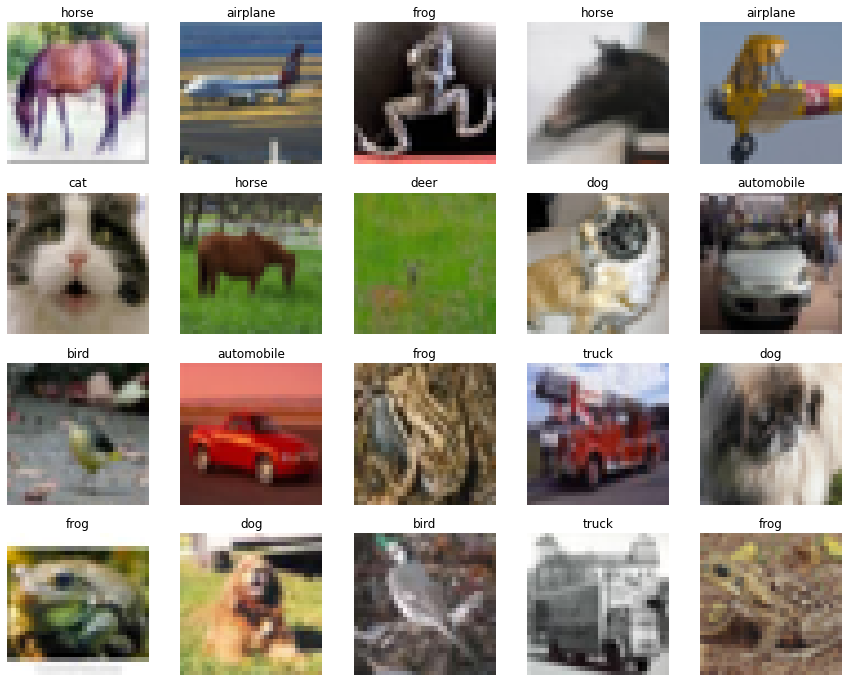

In [39]:
# 5. Showing a training batch
dls.train.show_batch(max_n=20, nrows=4)

##### 2. Training the CNN model for Bobcat detection using the resnet50 architecture

In [40]:
# Setting Seed for reproducible model
set_seed(88, True)

# Creating the model
learn = cnn_learner(dls, resnet50, metrics = accuracy, pretrained=True)

SuggestedLRs(valley=0.0010000000474974513)

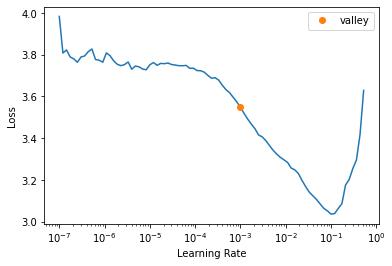

In [41]:
# Finding the appropiate value for a learning rate to train on the head of the CNN

learn.lr_find()

In [42]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.586133,1.312550,0.572727,11:34
1,0.976086,0.967822,0.702455,10:12
2,0.766782,0.695991,0.757182,10:09
3,0.626336,0.659484,0.776273,09:50
4,0.563312,0.659055,0.778091,09:48


In [43]:
# unfreeze the layers for finetuning

learn.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

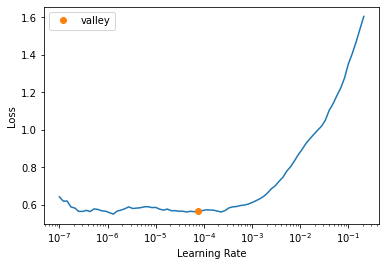

In [44]:
# Finding the appropiate value for a learning rate to train on the unfrozen layers

learn.lr_find()

In [48]:
# 2nd Run

learn.fit_one_cycle(5,slice(7e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.561587,0.579045,0.800636,20:13
1,0.432538,0.467850,0.840545,19:55
2,0.224721,0.477349,0.849273,19:51
3,0.080030,0.533536,0.854545,21:20
4,0.028438,0.542508,0.856182,23:52


##### 3. Results

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

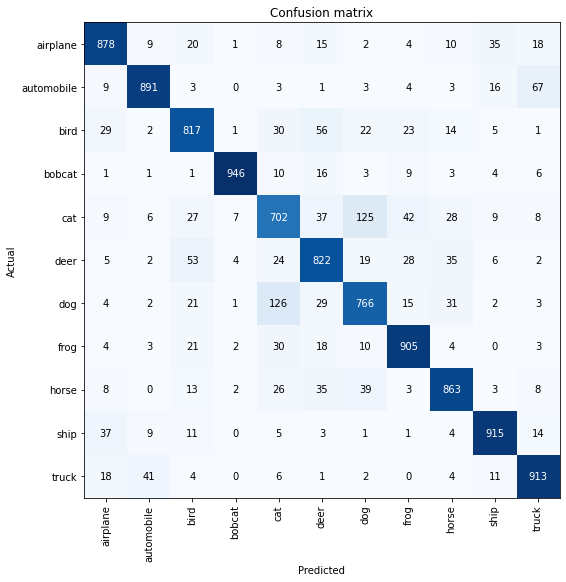

In [50]:
# Confusion Matrix
interp.plot_confusion_matrix(figsize=(8,8))

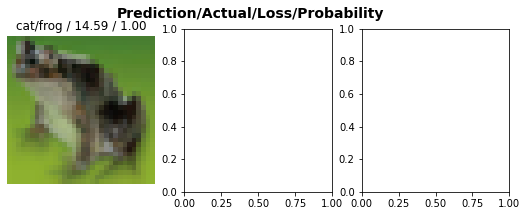

In [57]:
# Showing the biggest error
interp.plot_top_losses(3)

In [61]:
# Exporting the model
learn.export('C:/Users/User/Desktop/ENSF511_Lab2/models/bobcat.pkl')

##### 4. Discussion

Using the Fastai Library improves the user experience for model training, providing useful tools to visualize the process of what is happening on the dataset and the model. My personal favourite from the library is the lr_find() method, which recommends the learning rate. This allows an appropate learning rate to be used with lower epochs required depending on the number of batches to converge appropiately.

The model provided adequate performance for bobcat detection (an overall accuracy of **85.6%**) but falling short compared to the transferred layers where all layers were retrained on Part 1 (specifcally layer 1:7 with an overall accuracy of **89.7%**). I want to note that the model has some overfitting after unfreezing the layers for fine-tuning (i.e., 2nd run). This idea is upported by the increasing validation loss starting from the third epoch. I could avoid it by doing this process again given I that I have set the same seed for reproducibility, but with limited time, I could not work on improving the model a bit more. That aside, from the confusion matrix, the bobcat and cat accuracy was **94.6%** and **70.2%** respectively. It still falls a bit short to the retrained model when transferring layer 1:7 on Part 1 (bobcat and cat accuracy was **94.6%** and **70.2%** respectively).

Overall, the Fastai library was more comfortable for me to train the model with comparable performance given more time to finetune the model. ResNet50 looks like it can provide a good or even be a better model with higher layers when performing image detection.